In [1]:
#Choosing training/validation for Y3

#50/50 : start with 150 deg^2, 250 deg^2, 350 deg^2 – converge on limit for size
#*Random selection of parts of 624deg^2 to show invariance or not
#**reserve part of overlap region for science**

import os, sys
import esutil
import healpy as hp
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test
from sys_functions import *

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [4]:
# call required functions from modules 

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0008/warner785/bwarner/gold_full/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'gold_st82_final'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z',
            'COADD_OBJECT_ID', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z','EXTENDED_CLASS_MASH_SOF']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)

import esutil
import fitsio
import numpy as np
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)


Calling catalogs >>>
gold_st82_final_000056.fits
gold_st82_final_000003.fits
gold_st82_final_000026.fits
gold_st82_final_000121.fits
gold_st82_final_000094.fits
gold_st82_final_000040.fits
gold_st82_final_000010.fits
gold_st82_final_000082.fits
gold_st82_final_000068.fits
gold_st82_final_000075.fits
gold_st82_final_000103.fits
gold_st82_final_000112.fits
gold_st82_final_000043.fits
gold_st82_final_000125.fits
gold_st82_final_000083.fits
gold_st82_final_000101.fits
gold_st82_final_000016.fits
gold_st82_final_000031.fits
gold_st82_final_000041.fits
gold_st82_final_000052.fits
gold_st82_final_000092.fits
gold_st82_final_000027.fits
gold_st82_final_000127.fits
gold_st82_final_000095.fits
gold_st82_final_000114.fits
gold_st82_final_000079.fits
gold_st82_final_000045.fits
gold_st82_final_000086.fits
gold_st82_final_000007.fits
gold_st82_final_000029.fits
gold_st82_final_000055.fits
gold_st82_final_000076.fits
gold_st82_final_000069.fits
gold_st82_final_000105.fits
gold_st82_final_000100.fit

In [12]:
dmass_val = esutil.io.read('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_part2.fits')

In [5]:
dmass_spt = calling_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_spt.fits')

Resulting catalog size
DMASS= 341117.6414259936


In [9]:
#matching:
# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]

print(nocmass.size)

print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

5697739
('num of cmass in des side', 60037, '(23%)')


In [5]:
# notes:

# multiple selections for invariance check? *** 4 checks

# divided into healpix: instead of region, as well as
# even/odd: are selected separated --- random draw up to area wanted
#healpy -- google -- pix area: 150 deg^2 etc. 
# erin sheldon: healpix function **
#-- compare methods *****

#    mask4 =(sysMap['RA']>18)&(sysMap['RA']<43)
#    mask4 = mask4 & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
#    sysMap = sysMap[mask4]

In [10]:
def cutmap(sample, region):
    
    if region == 'validation':
        mask4 =(sample['RA']>18)&(sample['RA']<43)
        mask4 = mask4 & (sample['DEC']>-10) & (sample['DEC']<10)
        sample_cut = sample[mask4]
    if region == 'train':
        mask = (sample['RA']>310) & (sample['RA']<360)|(sample['RA']<7)
        mask = mask & (sample['DEC']>-10) & (sample['DEC']<10)
        sample_cut = sample[mask]
    if region == 'train1':
        mask = (sample['RA']>310) & (sample['RA']<358)
        mask = mask & (sample['DEC']>-10) & (sample['DEC']<10)
        sample_cut = sample[mask]
    
    return sample_cut

des_val = cutmap(gold_st82, 'validation')
des_y3_train = cutmap(gold_st82, 'train')
des_y1_train = cutmap(gold_st82, 'train1')

# One training/testing region used for all (three) validation tests: 100 deg^2
# healpix? -- if RA/DEC not
# RA DEC systematics tested to see if this is a good method

mask = (gold_st82['RA']>18) & (gold_st82['RA']<43)
mask = mask & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_train = gold_st82[mask]

# Training region for CMASS:
#mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
#                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
#cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
#cmass_mask_train[mg2] = 1
#clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

# SPT mask:

mask_spt = (dmass_spt['RA']>295)&(dmass_spt['RA']<360)|(dmass_spt['RA']<105)
mask_spt = mask_spt & (dmass_spt['DEC']>-68) & (dmass_spt['DEC']<-10)
gold_spt = dmass_spt[mask_spt]

#validation cookie cutter --- version 1: 250 deg^2 regions

#cut regions into RA and DEC:  
mask1 = (gold_st82['RA']<26)
mask1 = mask1 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v1 = gold_st82[mask1]

#validation cookie cutter --- version 2:

#cut regions into RA and DEC:  
mask2 =(gold_st82['RA']>26)&(gold_st82['RA']<70)
mask2 = mask2 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v2 = gold_st82[mask2]

In [9]:
'''#validation cookie cutter --- version 3:

#cut regions into RA and DEC:  
mask3 =(gold_st82['RA']>20)&(gold_st82['RA']<50)
mask3 = mask3 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v3 = gold_st82[mask3]
'''

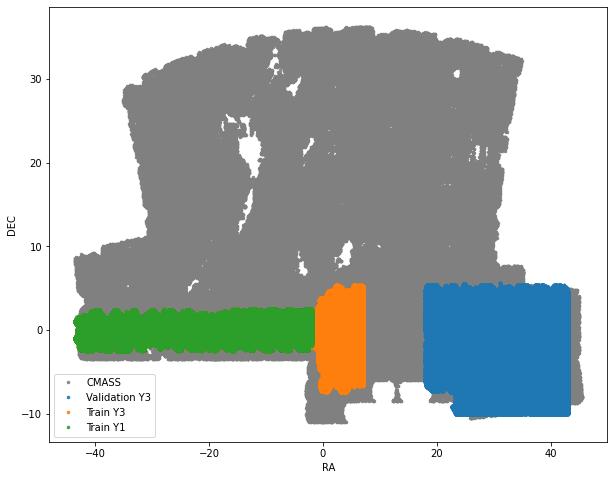

In [11]:
spatialcheck([cmass, des_val, des_y3_train, des_y1_train], 
             label = ['CMASS','Validation Y3', 'Train Y3', 'Train Y1'], convert = None, ratag='RA',dectag='DEC')

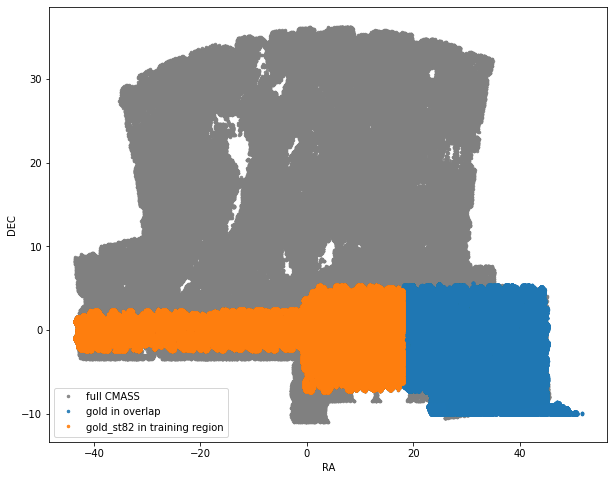

In [15]:
#checking footprint:

spatialcheck([cmass, gold_st82, gold_st82_train], 
             label = ['full CMASS', 'gold in overlap', 'gold_st82 in training region'], convert = None, ratag='RA',dectag='DEC')

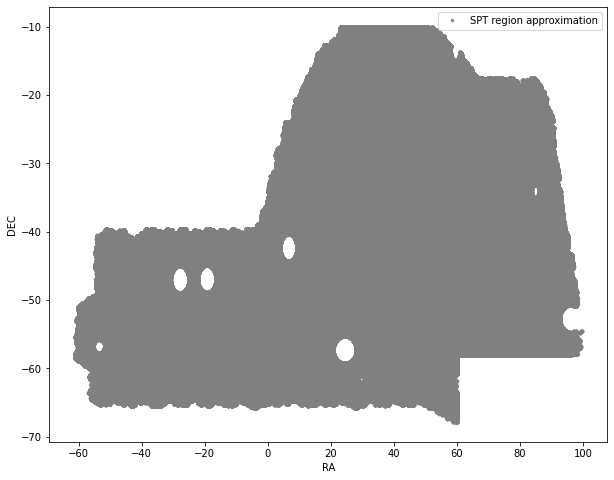

In [7]:
spatialcheck([gold_spt], 
             label = ['SPT region approximation'], convert = None, ratag='RA',dectag='DEC')

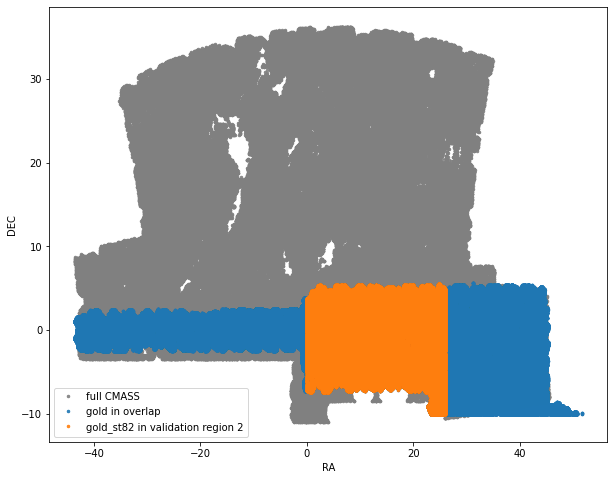

In [38]:
spatialcheck([cmass, gold_st82, gold_st82_v1], 
             label = ['full CMASS', 'gold in overlap', 'gold_st82 in validation region 2'], convert = None, ratag='RA',dectag='DEC')

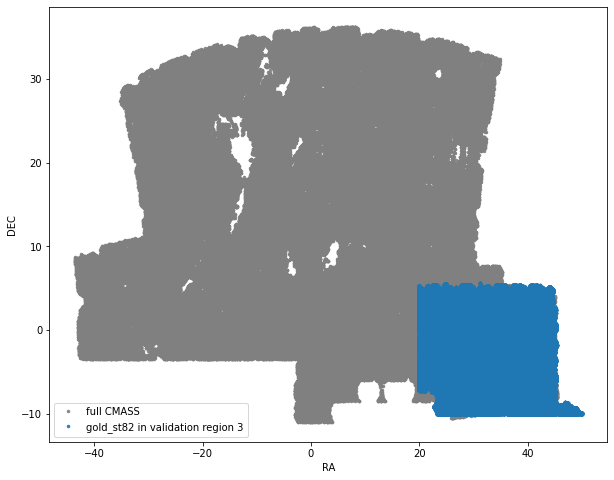

In [20]:
spatialcheck([cmass, gold_st82_v3], 
             label = ['full CMASS', 'gold_st82 in validation region 3'], convert = None, ratag='RA',dectag='DEC')

In [ ]:
#Checklist:

# make pickle for training region
# apply pickle on validation regions
# get DMASS sample in validation regions
# make figure 3 for all cases -- check DMASS sample close to CMASS first
# systematic check on 3 versions of DMASS sample
# systematic check on 3 versions of true CMASS sample
# true CMASS check on 3 versions of DMASS sample

In [6]:
# *** Checking actual area via healpix pixels
import healpy as hp

# calling Y3 GOLD footprint map
# downloaded from https://cdcvs.fnal.gov/redmine/projects/des-y3/wiki/Y3A2_Gold_footprint
#mapname='/global/homes/b/bwarner/DMASS/code/y3a2_footprint_griz_1exp_v2.0.fits.gz.1'
mapname = '/fs/scratch/PCON0003/warner785/bwarner/MASK_Y3LSSBAOSOF_22_3_v2p2.fits'
hpmap_y3gold = hp.read_map(mapname)
goodmask = hp.mask_good(hpmap_y3gold)
hpind_y3gold = np.arange(hpmap_y3gold.size)

'''
#making healpix IDs from RA and DEC
ra = train_sample['RA'] 
dec = train_sample['DEC']  
mask_cmass= hp.ang2pix(4096, ra, dec, lonlat = True) #converts ang. cor. to healpix ids

# Generate mask for cmass
mask_train = np.in1d(mask_cmass, hpind_y3gold[goodmask])

# Apply mask to extract cmass in the Y3 gold region
# This results 76722 CMASS galaxies
train_sample = mask_cmass[mask_train]
'''

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT
Ordering converted to RING


"\n#making healpix IDs from RA and DEC\nra = train_sample['RA'] \ndec = train_sample['DEC']  \nmask_cmass= hp.ang2pix(4096, ra, dec, lonlat = True) #converts ang. cor. to healpix ids\n\n# Generate mask for cmass\nmask_train = np.in1d(mask_cmass, hpind_y3gold[goodmask])\n\n# Apply mask to extract cmass in the Y3 gold region\n# This results 76722 CMASS galaxies\ntrain_sample = mask_cmass[mask_train]\n"

In [7]:
ra_hpmap_y3gold, dec_hpmap_y3gold = hpHEALPixelToRaDec( hpind_y3gold[goodmask], nside = 4096, nest=False )
mask_hpmap_y3gold_spt = dec_hpmap_y3gold < -10.0

pixarea = hp.nside2pixarea( 4096, degrees = True)
npix_spt =  np.sum(mask_hpmap_y3gold_spt)
SPTMapArea = pixarea * npix_spt

print ('<Survey Area> \n-This is a rough estimation')
print ('spt region (dec < -10.0):{:5.0f} sq.deg'.format(SPTMapArea) )

<Survey Area> 
-This is a rough estimation
spt region (dec < -10.0): 3525 sq.deg


In [8]:
# convert hp indices to ra/dec and split into regions. 
# Apply a rough cut (DEC > -10.0) for st82 overlap
ra_hpmap_y3gold, dec_hpmap_y3gold = hpHEALPixelToRaDec( hpind_y3gold[goodmask], nside = 4096, nest=False )
mask_hpmap_y3gold_training = dec_hpmap_y3gold > -10.0

mask_hpmap_training = (ra_hpmap_y3gold>310) & (ra_hpmap_y3gold<360)|(ra_hpmap_y3gold<7)
mask_hpmap_training = mask_hpmap_training & (dec_hpmap_y3gold >-10) & (dec_hpmap_y3gold<10)
mask_hpmap_v1 = (ra_hpmap_y3gold<26)
mask_hpmap_v1 = mask_hpmap_v1 & (dec_hpmap_y3gold >-10) & (dec_hpmap_y3gold<10)
mask_hpmap_v2 = (ra_hpmap_y3gold>26) & (ra_hpmap_y3gold<70)
mask_hpmap_v2 = mask_hpmap_v2 & (dec_hpmap_y3gold >-10) & (dec_hpmap_y3gold<10)
#mask_hpmap_v3 = (ra_hpmap_y3gold<45) & (ra_hpmap_y3gold>24)|(ra_hpmap_y3gold<330) & (ra_hpmap_y3gold>300)
#mask_hpmap_v3 = mask_hpmap_v3 & (dec_hpmap_y3gold >-10) & (dec_hpmap_y3gold<10)

#mask_hpmap_y3gold_testing = dec_hpmap_y3gold < -10.0

pixarea = hp.nside2pixarea( 4096, degrees = True)
npix_training =  np.sum(mask_hpmap_y3gold_training)
npix_training1 =  np.sum(mask_hpmap_training)
npix_v1 =  np.sum(mask_hpmap_v1)
npix_v2 =  np.sum(mask_hpmap_v2)
#npix_v3 =  np.sum(mask_hpmap_v3)

#npix_testing = np.sum(mask_hpmap_y3gold_testing)
TrainingMapArea = pixarea * npix_training
Training1MapArea = pixarea * npix_training1
V1MapArea = pixarea * npix_v1
V2MapArea = pixarea * npix_v2
#V3MapArea = pixarea * npix_v3

#TestingMapArea = pixarea * npix_testing
print ('<Survey Area> \n-This is a rough estimation')
print ('training region (dec > -10.0):{:5.0f} sq.deg'.format(TrainingMapArea) )

print ('mock training region :{:5.0f} sq.deg'.format(Training1MapArea) )
print ('validation 1 region :{:5.0f} sq.deg'.format(V1MapArea) )
print ('validation 2 region :{:5.0f} sq.deg'.format(V2MapArea) )
#print ('validation 3 region :{:5.0f} sq.deg'.format(V3MapArea) )

#print ('testing region  (dec < -10.0):{:5.0f} sq.deg'.format(TestingMapArea) )

<Survey Area> 
-This is a rough estimation
training region (dec > -10.0):  624 sq.deg
mock training region :  203 sq.deg
validation 1 region :  246 sq.deg
validation 2 region :  237 sq.deg


In [15]:
ra_hpmap_y3gold, dec_hpmap_y3gold = hpHEALPixelToRaDec( hpind_y3gold[goodmask], nside = 4096, nest=False )
mask_hpmap_y3gold_training = dec_hpmap_y3gold > -10.0

mask_hpmap_training = (ra_hpmap_y3gold>18) & (ra_hpmap_y3gold<43)
mask_hpmap_training = mask_hpmap_training & (dec_hpmap_y3gold >-10) & (dec_hpmap_y3gold<10)

pixarea = hp.nside2pixarea( 4096, degrees = True)
npix_training =  np.sum(mask_hpmap_training)

TrainingMapArea = pixarea * npix_training
print ('<Survey Area> \n-This is a rough estimation')
print ('training region (dec > -10.0):{:5.0f} sq.deg'.format(TrainingMapArea) )

<Survey Area> 
-This is a rough estimation
training region (dec > -10.0):  296 sq.deg


In [ ]:
#another mask:
#divide training region into two parts 50/50

###(use full "overlap" for training, and real overlap for validation? -- does not get rid of usable area this way)

#try: use half of overlap: 150 deg^2 for training, rest for validation

#validation: solid: 300 deg^2 --------- always have same error bars, **differences between patches? -- check galaxy number density
# overlap size versus how well training is doing -- random fluc. 
# limit methods of selection of sample, chunks of sample

# ***random healpixels in 300 deg^2 in training (for each three) -- nside 64 (nside 8?): larger patches to randomly sample ** ;;check sizes of pixels
# future analysis problems with random? 

# getting initial result first ** -- 
# 1) 300 deg^2: for validation, selected by scattered over overlap (plot this): nside 8 (7 deg^2) -- (continuous through process)
# 2) training: check with all, 1/3, etc. 
# 3) output: figure 3 as check

mask_half = gold_st82['RA'] < 320
gold_st82_train = gold_st82[mask_half] #-- y1: gold_st82
gold_st82_test = gold_st82[~mask_half] #-- y1: gold_spt (same method)

In [10]:
# Apply matching over only training region

#matching:
# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample_1['RA'], train_sample_1['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask], gold_st82_train[~cmass_mask]

print(nocmass_train.size)

print(('num of cmass in des side', clean_cmass_data_des_train.size, '({:0.0f}%)'.format(clean_cmass_data_des_train.size*1./cmass.size*100.)))

1387752
('num of cmass in des side', 10634, '(4%)')


In [ ]:
# check magnitudes (one band of mag) for y1 and for these y3 matches: histogram of magnitude

In [11]:
# Create Pickle File:
# call training samples
outdir = '../output/test/'
clean_cmass_data_des = clean_cmass_data_des_train
nocmass = nocmass_train

In [49]:
# For a fast run, we draw a random sample to reduce the sample size. 
# Larger sample tends to make a better model but the sample size is not always proportional to the accuracy of the model. 

# Put sample size you want 

n_sample =  int(clean_cmass_data_des.size)  # train cmass sample size
n_sample_non = int(nocmass.size/20)  # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass.size), size = n_sample_non )
nocmass_sub = nocmass[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des.size *1./gold_st82_train.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

random sampling... 
num of randomly sampled cmass  10634
num of randomly sampled non-cmass  69387
cmass_fraction (cmass/non-cmass):  0.007604481166144398


In [50]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_cmass = 500  
n_iter_no = 10
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
cmass_pickle = outdir+'gauss_cmass_testy3.pkl'
no_pickle = outdir+'gauss_no_testy3.pkl'

In [51]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [52]:
# Run XD Fitting. This will take a while 
clf_cmass = XD_fitting_X( X_cmass_true, X_cmass_cov, pickleFileName = cmass_pickle, 
                       n_cl = n_cmass, n_iter = n_iter_cmass, tol = tol, 
                       verbose = True, init_params= None)                 
clf_no = XD_fitting_X( X_no_true, X_no_cov, pickleFileName = no_pickle, 
                    n_cl = n_no, n_iter = n_iter_no, tol = tol, 
                    verbose = True, init_params = None)

@pickle_results: computing results and saving to '../output/test/fitting/gauss_cmass_testy3.pkl'
@pickle_results: computing results and saving to '../output/test/fitting/gauss_cmass_testy3.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  6
n components = 6
tolerance = 1e-05


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


1: log(L) = 38084.71565
    (1.1 sec)
2: log(L) = 38150.88368
    (1.1 sec)
3: log(L) = 38209.81901
    (0.99 sec)
4: log(L) = 38260.8457
    (1.1 sec)
5: log(L) = 38305.03858
    (1 sec)
6: log(L) = 38344.75747
    (1 sec)
7: log(L) = 38379.51463
    (1.1 sec)
8: log(L) = 38408.68569
    (1.1 sec)
9: log(L) = 38433.30127
    (1.1 sec)
10: log(L) = 38454.73894
    (1 sec)
11: log(L) = 38473.98834
    (1 sec)
12: log(L) = 38491.25771
    (0.99 sec)
13: log(L) = 38506.23516
    (1.1 sec)
14: log(L) = 38518.84676
    (1.1 sec)
15: log(L) = 38529.3629
    (1.1 sec)
16: log(L) = 38538.12844
    (1.1 sec)
17: log(L) = 38545.45534
    (1.1 sec)
18: log(L) = 38551.61032
    (1.1 sec)
19: log(L) = 38556.81521
    (1.1 sec)
20: log(L) = 38561.24995
    (1 sec)
21: log(L) = 38565.05837
    (1.1 sec)
22: log(L) = 38568.35505
    (0.98 sec)
23: log(L) = 38571.23157
    (1.1 sec)
24: log(L) = 38573.76162
    (1.1 sec)
25: log(L) = 38576.00489
    (1 sec)
26: log(L) = 38578.00999
    (1.1 sec)
27: lo

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


n components = 36
tolerance = 1e-05
1: log(L) = 111814.8394
    (16 sec)
2: log(L) = 112453.564
    (16 sec)
3: log(L) = 112913.9381
    (16 sec)
4: log(L) = 113290.8322
    (16 sec)
5: log(L) = 113620.834
    (16 sec)
6: log(L) = 113919.0618
    (16 sec)
7: log(L) = 114187.7111
    (16 sec)
8: log(L) = 114425.9798
    (16 sec)
9: log(L) = 114637.4917
    (16 sec)
10: log(L) = 114829.5338
    (16 sec)
elapsed time: 2.35 min,  total iteration 9                                 


In [ ]:
# FIGURE 3

clf_cmass = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_cmass_testy3.pkl')               
clf_no = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_no_testy3.pkl')

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y3 in Stripe 82 Training/Testing Region.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

mask_half = gold_st82['RA'] < 320
gold_st82_train = gold_st82[mask_half] #-- y1: gold_st82
gold_st82_test = gold_st82[~mask_half] #-- y1: gold_spt (same method)

mask_half = clean_cmass_data_des['RA'] < 320
cmass_train = clean_cmass_data_des[mask_half]
cmass_test = clean_cmass_data_des[~mask_half]


clean_dmass_prob = assignCMASSProb(cmass_test, clf_cmass, clf_no, 
                     cmass_fraction =cmass_fraction
, 
                     mag=mag, err=err, filter=filter ) 
#dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob.fits')
#this is simply gold_st82 with all cuts made
#XD of y1 gold des in st82 -- with membership probability
dmass_st82 = clean_dmass_prob # actual CMASS gal in val set

gold_st82_val = assignCMASSProb(gold_st82_test, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )

# Assigning CMASS probabilities to Gold Y3 in Validation Region.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']
gold_spt_test = assignCMASSProb(gold_spt_random, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )
#dmass_spt = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
#gold_spt data
#XD of y1 gold des in spt -- with membership probability
dmass_spt = gold_spt_test

print(cmass_fraction)

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(gold_st82_val['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo.pdf')

In [ ]:
###FIGURE 4:

clf_cmass = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_cmass_v4.pkl')               
clf_no = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_no_v4.pkl')

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']

mask_half = gold_st82['RA'] < 320
gold_st82_train = gold_st82[mask_half] #-- y1: gold_st82
gold_st82_test = gold_st82[~mask_half] #-- y1: gold_spt (same method)

mask_half = clean_cmass_data_des['RA'] < 320
cmass_train = clean_cmass_data_des[mask_half]
cmass_test = clean_cmass_data_des[~mask_half]


clean_dmass_prob = assignCMASSProb(clean_cmass_data_des, clf_cmass, clf_no, 
                     cmass_fraction =cmass_fraction
, 
                     mag=mag, err=err, filter=filter ) 
#dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob.fits')
#this is simply gold_st82 with all cuts made
#XD of y1 gold des in st82 -- with membership probability
dmass_st82 = clean_dmass_prob # actual CMASS gal in val set

gold_st82_val = assignCMASSProb(gold_st82, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )

# Assigning CMASS probabilities to Gold Y1 in SPT.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']
gold_spt_test = assignCMASSProb(gold_spt_random, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter )
#dmass_spt = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
#gold_spt data
#XD of y1 gold des in spt -- with membership probability
dmass_spt = gold_spt_test

print(cmass_fraction)